# Classifiying MNIST-digits using the TensorFlow Layers-API

This notebook requires Python 3.5 and Tensorflow 1.0

In [1]:
import sys
import time
import datetime
from collections import Counter

import numpy as np

import tensorflow as tf
from tensorflow.contrib import learn

import matplotlib.pyplot as plt
% %matplotlib inline

/Users/michaelmuckel/anaconda/envs/tf10/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Load MNIST-data

The digits and the labels for both training and test datasets are loading via TFLearn, which provide sample datasets and functions to load them quite easily.

In [2]:
# set the two required directories
LOG_DIR = './tmp/'      # includes logging-outputs for Tensorboard
DATA_DIR = './data/'    # contains raw MNIST dataset

In [3]:
print('Retrieving MNIST-dataset ...')
mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=DATA_DIR, one_hot=True)

Retrieving MNIST-dataset ...
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [4]:
train_data = mnist.train.images 
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.validation.images
eval_labels = np.asarray(mnist.validation.labels, dtype=np.int32)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

num_train_examples = train_data.shape[0]
num_eval_examples = eval_data.shape[0]
num_test_examples = test_data.shape[0]

print("Training data    : ", train_data.shape)
print("Evaluation data  : ", eval_data.shape)
print("Testing data     : ", test_data.shape)
print("Training labels  : ", train_labels.shape)
print("Evaluation labels: ", eval_labels.shape)
print("Testing labels   : ", test_labels.shape)

Training data    :  (55000, 784)
Evaluation data  :  (5000, 784)
Testing data     :  (10000, 784)
Training labels  :  (55000, 10)
Evaluation labels:  (5000, 10)
Testing labels   :  (10000, 10)


In [5]:
# Prepare given images for processing in conv-net
def prepare_images(digits, normalize=True):
    """Transform an array digits-images into the format suitable for training a Conv-Net. """
    
    if normalize == True:
        MEAN = np.mean(mnist.train.images)
        STD = np.std(mnist.train.images)
        transformed_digits = (digits - MEAN) / STD
    else:
        transformed_digits = digits
    
    return np.reshape(transformed_digits, [-1, 28, 28, 1]) 

### Visualize a sample of the images

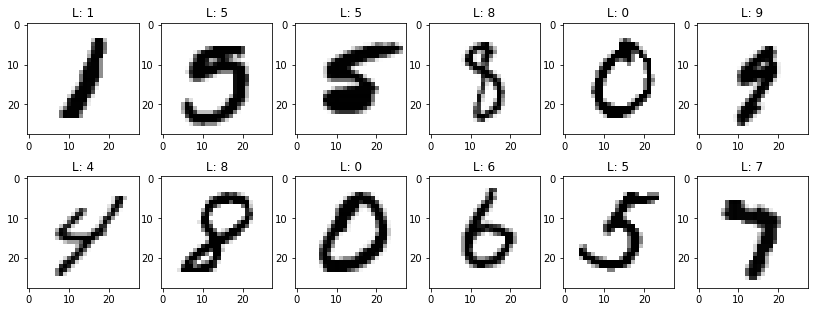

In [6]:
# Function for displaying a training image by it's index in the MNIST set
def show_digits(data, labels, indexes, predictions=None):
    """Renders the digits and the corresponding labels for the given indicies."""
    per_row = 6
    rows = int((len(indexes) / per_row) + 1)
    cols = per_row

    plt.figure(figsize=(14, 8))
    for i, index in enumerate(indexes):
        
        plt.subplot(rows, cols, (i) + 1)
        label = labels[index].argmax(axis=0)
        # Reshape 784 array into 28x28 image
        image = data[index].reshape([28,28])
        if predictions == None:
            plt.title('L: %d' % (label))
        else:
            plt.title('L: %d,  P: %d' % (label, predictions[i]))
        plt.imshow(image, cmap='gray_r')
    
    plt.show()
    
# Display the first (index 0) training image
train_samples_idx = [int(np.random.sample() * len(train_data)) for i in range(12)] 
show_digits(train_data, train_labels, train_samples_idx)


### Build the model

In [7]:
# Build model with straight-forward convolutional network architecture
def build_model(input, is_training=True, scope='conv--net'):
    
    with tf.variable_scope(scope, 'ConvNet'):
        
        net = tf.layers.conv2d(input, filters=20, kernel_size=(5, 5), padding='SAME', name='layer-01-conv')
        net = tf.layers.max_pooling2d(net, 2, strides=2, name='layer-02-maxpool')
        
        net = tf.layers.conv2d(net, 40, (5, 5), padding='VALID', name='layer-03-conv')
        net = tf.layers.max_pooling2d(net, 2, strides=2, name='layer-04-maxpool')
        
        net = tf.reshape(net, [-1, 5*5*40])
        net = tf.layers.dense(net, 1000, name='layer-05-dense')
        net = tf.layers.dropout(net, training=is_training, name='layer5-dropout')
        
        net = tf.layers.dense(net, 10, name='layer-06-output-dense')
        
        return net

### Train the model

In [8]:
# use this line to reset graph to start a new graph
tf.reset_default_graph()

# Define placeholders for training and evaluating the model
X = tf.placeholder(tf.float32, [None, 28, 28, 1], name='Inputs')
y = tf.placeholder(tf.float32, [None, 10], name='Labels')
is_training = tf.placeholder(tf.bool, name="is_training")

# build the model graph
logits = build_model(X, is_training)

In [9]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
correct_predictions = tf.equal(tf.argmax(logits, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

train_step = tf.train.MomentumOptimizer(0.01, 0.5).minimize(cross_entropy)

In [10]:
# Define the two metrics that will be visualized in Tensorboard
loss_summary = tf.summary.scalar('loss', cross_entropy)
accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [11]:
def print_status_line(str):
    sys.stdout.write('\r')
    sys.stdout.flush()
    print(str, end='')

In [12]:
epochs = 10
batch_size = 128
global_step = 0
num_batches = int(num_train_examples / batch_size)

evaluate_accurracy_data = {
    X: prepare_images(eval_data),
    y: eval_labels,
    is_training: False
}

session = tf.InteractiveSession()
    
session.run(tf.global_variables_initializer());
run_dir = "log-" + datetime.datetime.now().strftime('%Y%m%d_%H%M')
train_writer = tf.summary.FileWriter('./tmp/' + run_dir, session.graph )   
    
print("Starting training loop ...")
    
images_per_second = 0
    
# run number of epoches
for e in range(epochs):
        
    start_time = time.time()
    batch_count = 0
        
    # run training with individual batches until training data is depleated
    for _ in range(int(num_train_examples / batch_size)):
        batch_count += 1
        global_step += 1
            
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
            
        summary, _ = session.run([loss_summary, train_step], 
                                 feed_dict={X: prepare_images(batch_images), 
                                            y: batch_labels, 
                                            is_training: True})
        train_writer.add_summary(summary, global_step)
            
        if batch_count % 20 == 0:
            elapsed =  time.time() - start_time
            num_images_processes = 20 * batch_size
            images_per_second = float(num_images_processes) / elapsed
            start_time = time.time()
                
            
        # print progress and basic stats
        if batch_count % 10 == 0:
            status = "Epoche: {} Batch: {}  of {}  [{:.1f} %]  - Images per sec: {:.1f}".format(e + 1, batch_count, num_batches, 100* (float(batch_count) / num_batches), images_per_second)
            print_status_line(status)
                
        
    # print validation accuracy after each epoche
    summary, acc = session.run([accuracy_summary, accuracy], feed_dict=evaluate_accurracy_data)
    train_writer.add_summary(summary, global_step)
    print("\n   Validation Accuracy = %5.2f%%" % (acc * 100))
            

print("Training finished.")
        
    

Starting training loop ...
Epoche: 1 Batch: 420  of 429  [97.9 %]  - Images per sec: 322.3
   Validation Accuracy = 95.60%
Epoche: 2 Batch: 420  of 429  [97.9 %]  - Images per sec: 322.4
   Validation Accuracy = 97.34%
Epoche: 3 Batch: 420  of 429  [97.9 %]  - Images per sec: 322.0
   Validation Accuracy = 97.76%
Epoche: 4 Batch: 420  of 429  [97.9 %]  - Images per sec: 324.0
   Validation Accuracy = 97.96%
Epoche: 5 Batch: 420  of 429  [97.9 %]  - Images per sec: 292.8
   Validation Accuracy = 98.16%
Epoche: 6 Batch: 420  of 429  [97.9 %]  - Images per sec: 322.3
   Validation Accuracy = 98.14%
Epoche: 7 Batch: 420  of 429  [97.9 %]  - Images per sec: 321.9
   Validation Accuracy = 98.60%
Epoche: 8 Batch: 420  of 429  [97.9 %]  - Images per sec: 318.4
   Validation Accuracy = 98.64%
Epoche: 9 Batch: 420  of 429  [97.9 %]  - Images per sec: 322.2
   Validation Accuracy = 98.70%
Epoche: 10 Batch: 420  of 429  [97.9 %]  - Images per sec: 321.7
   Validation Accuracy = 98.68%
Training fin

### Evaluate the result

Use the test-examples to calculate the accuracy of the model.

In [13]:
test_data_accuracy = {
    X: prepare_images(test_data),
    y: test_labels,
    is_training: False
}

acc, predictions = session.run([accuracy, logits], feed_dict=test_data_accuracy)
print("Test Accuracy = %5.2f%%" % (100 * acc))

Test Accuracy = 98.75%


Let's check how many digits have been misclassified and if the classification accuracy differs for the individual types of digits.

In [14]:
# get all indices of digits that were not classified correctly.
total_misclassified_count = 0
misclassified_idx  = list()
misclassified_pred = list()

for idx in range(len(predictions)):
    
    if np.argmax(predictions[idx]) != np.argmax(test_labels[idx]):
        total_misclassified_count += 1
        misclassified_idx.append(idx)
        misclassified_pred.append(np.argmax(predictions[idx]))
        
print("Misclassified: %d of %d" % (total_misclassified_count, len(predictions)))

Misclassified: 125 of 10000


[(0, 3), (1, 3), (2, 13), (3, 15), (4, 3), (5, 16), (6, 10), (7, 13), (8, 23), (9, 26)]


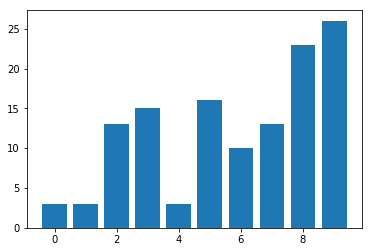

In [15]:
misclassified_counter = Counter()
for idx in misclassified_idx:
    misclassified_counter[np.argmax(test_labels[idx])] += 1
    
sorted_digits = sorted(misclassified_counter.items())
print(sorted_digits)

x_axis = [x[0] for x in sorted_digits]
y_axis = [x[1] for x in sorted_digits]
plt.bar(x_axis, y_axis)
plt.show()

Finally, let's take a look at some sample from the digits that have not been classified correctly

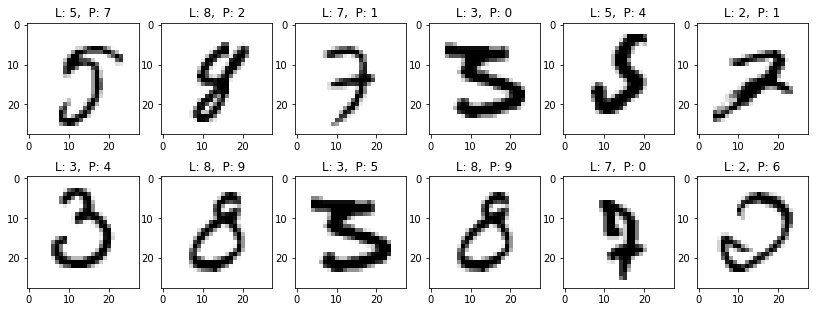

In [18]:
# Display the first (index 0) training image
samples = [int(np.random.sample() * len(misclassified_idx)) for i in range(12)]
misclassified_samples_idx = [ misclassified_idx[i] for i in samples]
show_digits(test_data, test_labels, misclassified_samples_idx, [np.argmax(p) for p in predictions])
